IMPORTS

In [ ]:
pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=b6b3650c08a205ef803780a491c26e191639421474eaf84e52073e7f66aeb323
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=cf193875da183c8fb312e44d3db35fc17cb1caf7c210102a8c9938b50a2568dd
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


LOAD Data (1 Hr data) and import necessary modules

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf,pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

#downloading hourly btc/usd data and preparing a list of open,high,low and close prices
url='https://drive.google.com/file/d/1ablFbgH1Tn3OX85dqdzJkYWaX6dtHWx1/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id='+file_id
data=pd.read_csv(dwn_url)
data=data[data['volume']!=0]
data.reset_index(drop=True, inplace=True)
print(data.isna().sum()) #for checking null values
open = data.loc[:,"open"]
high = data.loc[:,"high"]
low = data.loc[:,"low"]
close = data.loc[:,"close"]
time = data.loc[:,"datetime"]
ts_list = [open,high,low,close]#list of all the time series data


datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64


In [ ]:
# Dickey - fuller Test to determine if the data is stationary or not
def dickey_fuller_test(ts):
    adfuller_result = adfuller(ts)
    print('ADF Statistic: %f' % adfuller_result[0])
    print('p-value: %f' % adfuller_result[1])
    print('Critical Values :')
    for key,value in adfuller_result[4].items():
        print('\t%s : %.3f' % (key,value))

for ts in ts_list:
    print(ts.name)
    dickey_fuller_test(ts)
    #since the p-values for the ADF tests are greater than 0.05 for all the price timeseries, we can conclude that the data is non stationary

open
ADF Statistic: -0.598371
p-value: 0.871350
Critical Values :
	1% : -3.431
	5% : -2.862
	10% : -2.567
high
ADF Statistic: -0.585954
p-value: 0.874124
Critical Values :
	1% : -3.431
	5% : -2.862
	10% : -2.567
low
ADF Statistic: -0.594057
p-value: 0.872319
Critical Values :
	1% : -3.431
	5% : -2.862
	10% : -2.567
close
ADF Statistic: -0.600978
p-value: 0.870761
Critical Values :
	1% : -3.431
	5% : -2.862
	10% : -2.567


In [ ]:
#function to visualize the trend, seasonal component and the residual in the data
def seasonal_decompose_data(ts,type,period):
  decomposed = seasonal_decompose(ts,model = type,period=period)
  fig = plt.figure()
  fig = decomposed.plot()
  fig.set_size_inches(15,10)

<Figure size 640x480 with 0 Axes>

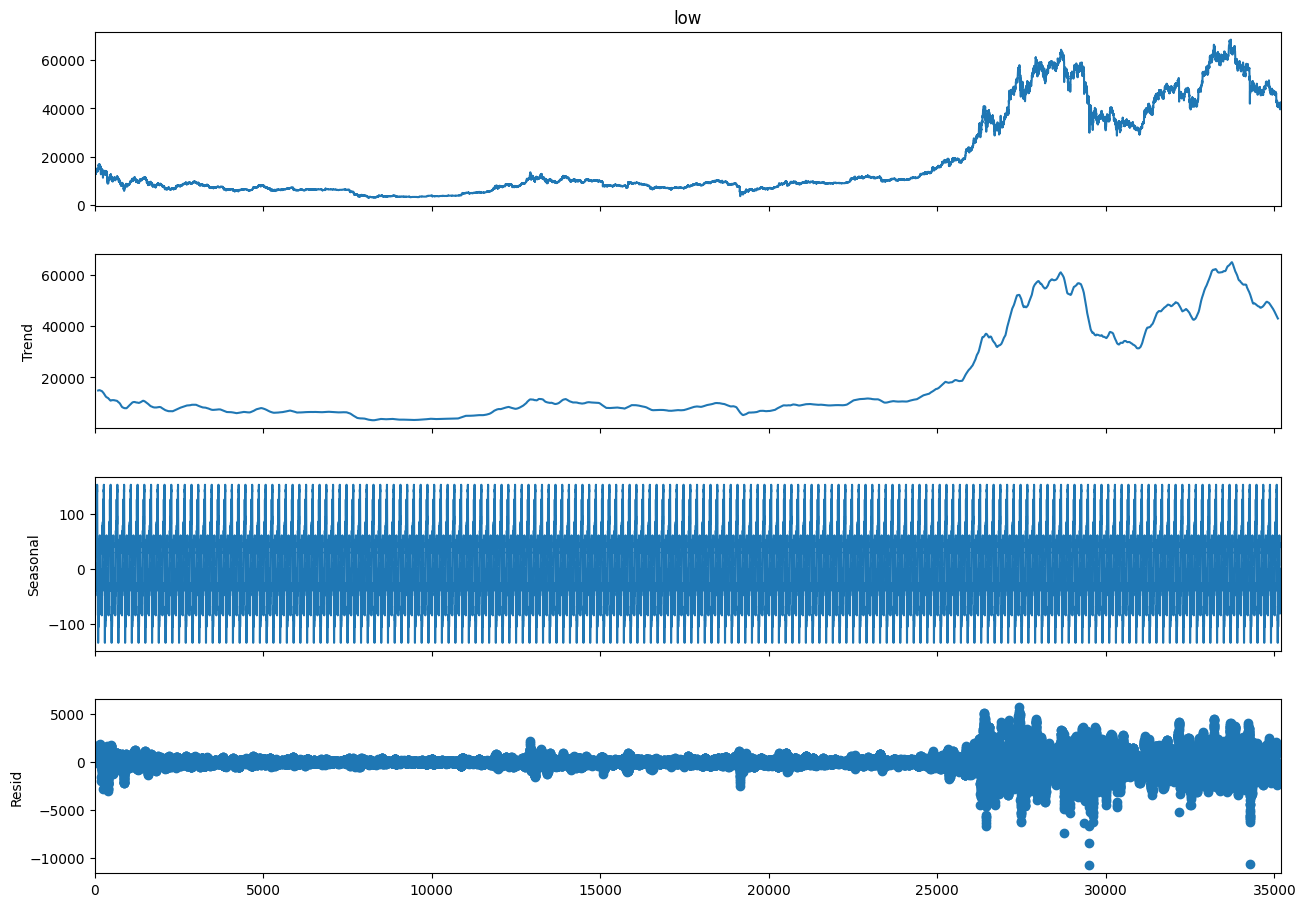

In [ ]:
seasonal_decompose_data(low,"additive",200)#decomposing the low prices data into its trend, seasonal and error terms assuming low prices have additive seasonal components

<Figure size 640x480 with 0 Axes>

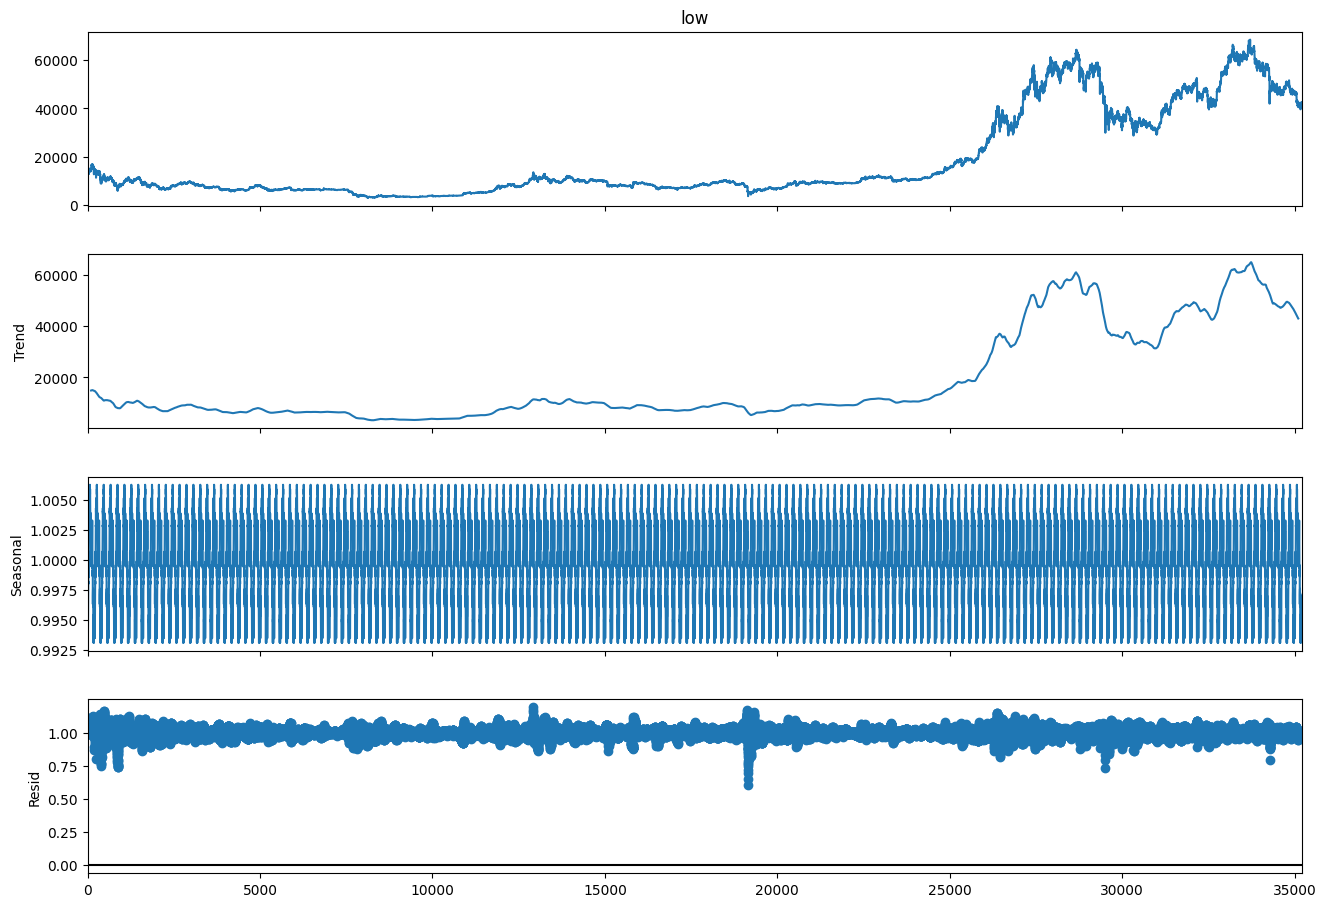

In [ ]:
seasonal_decompose_data(low,"multiplicative",200)#decomposing the low prices data into its trend, seasonal and error terms assuming low prices have multiplicative seasonal components

<Figure size 640x480 with 0 Axes>

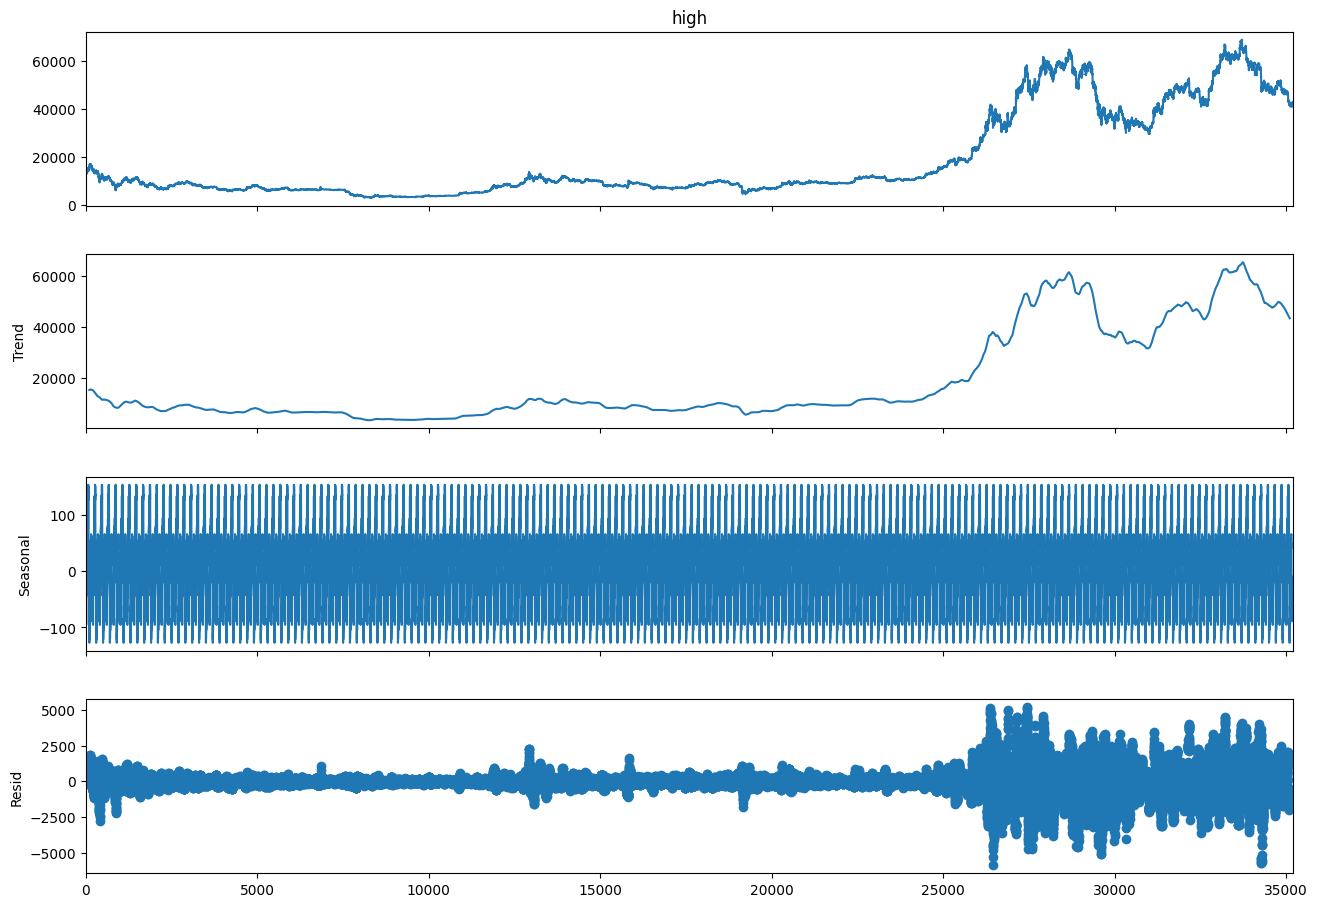

In [ ]:
seasonal_decompose_data(high,"additive",200)#decomposing the high prices data into its trend, seasonal and error terms assuming high prices have additive seasonal components


<Figure size 640x480 with 0 Axes>

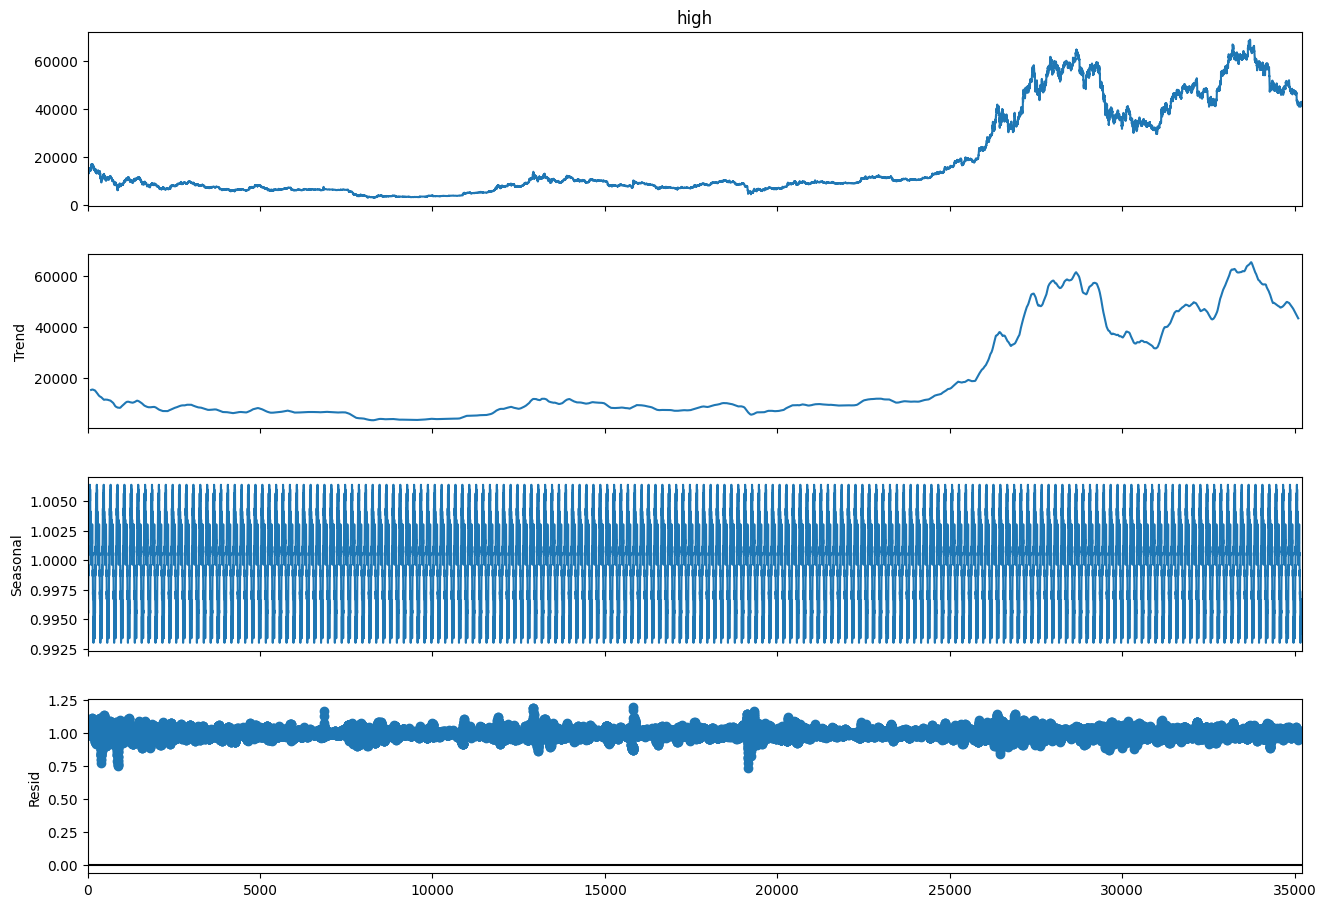

In [ ]:
seasonal_decompose_data(high,"multiplicative",200)#decomposing the high prices data into its trend, seasonal and error terms assuming low prices have multiplicative seasonal components

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

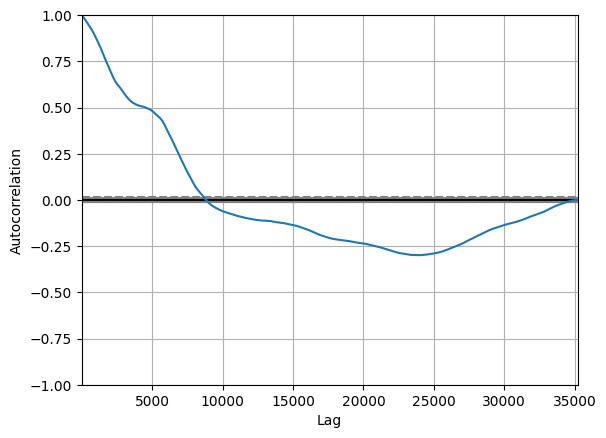

In [ ]:
pd.plotting.autocorrelation_plot(high) #plotting the autocorrelation plot of the price timeseries (used for determining p)

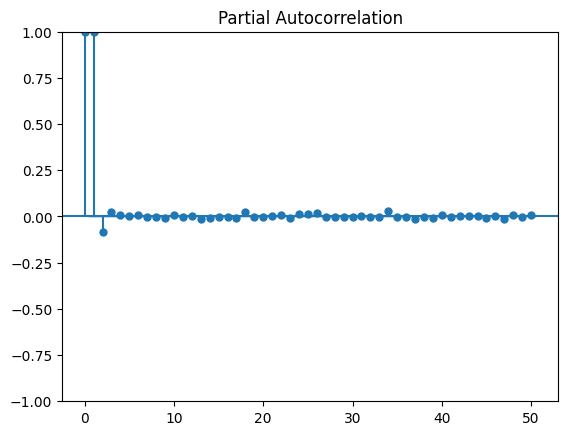

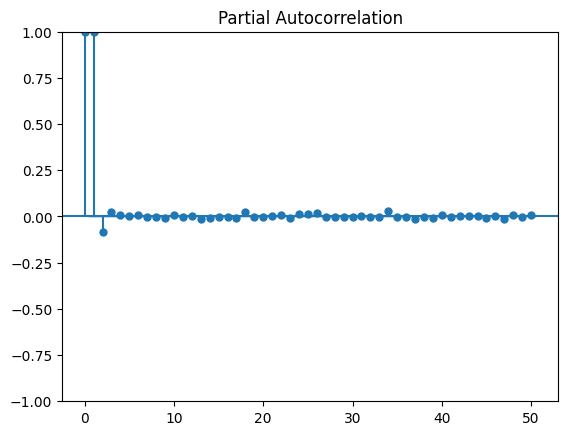

In [ ]:
plot_pacf(high,lags = 50)#plotting the partial autocorrelation plot of the price timseries (used for determining q)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

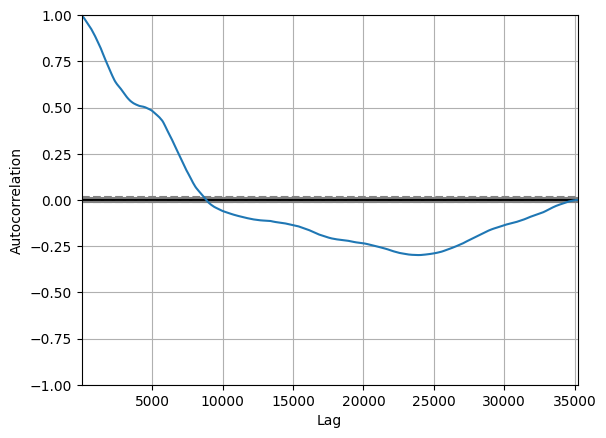

In [ ]:

pd.plotting.autocorrelation_plot(low) #plotting the autocorrelation plot of the price timeseries (used for determining p)

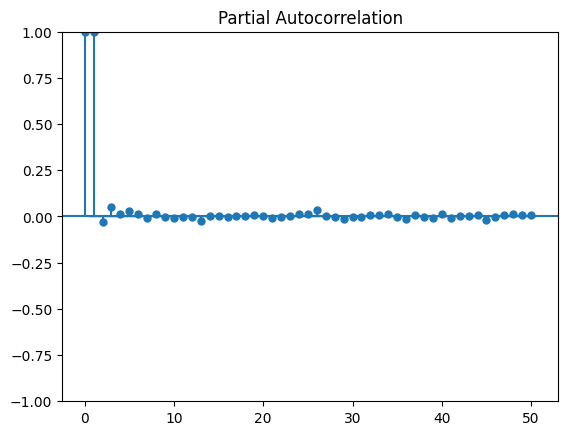

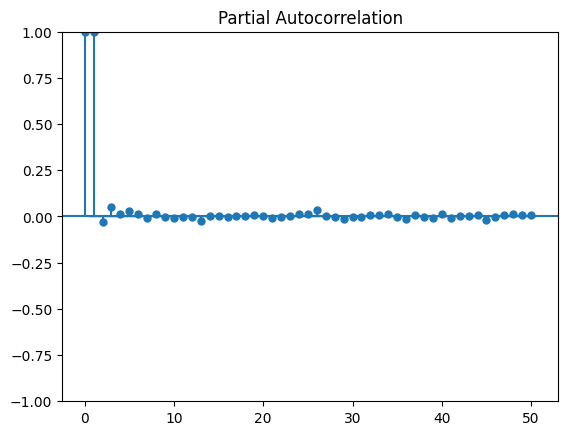

In [ ]:
plot_pacf(low,lags = 50)#plotting the partial autocorrelation plot of the price timseries (used for determining q)

In [ ]:
#function for determining the value of p,d,q for ARIMA model, which we use for predicting future btc/usdt prices
def determine_p_d_q_values(timeseries,lags):
    autocorr_values = acf(timeseries,nlags = lags)
    pacf_values = pacf(timeseries,nlags = lags)

    p_value = 0
    for i in range(1,len(autocorr_values)):
        if (abs(autocorr_values[i]) > 1.96 / len(timeseries)**0.5):
            p_value = i
            break

    d_value = 0
    p_value_adf = adfuller(timeseries)[1]
    while p_value_adf > 0.05:
        timeseries = np.diff(timeseries)
        d_value += 1
        p_value_adf = adfuller(timeseries)[1]

    q_value = 0
    for i in range(1,len(pacf_values)):
        if (abs(pacf_values[i]) > 1.96 / len(timeseries)**0.5):
            q_value =   i
            break

    return p_value,d_value,q_value



In [ ]:
p_d_q_dict = {}
for ts in ts_list:
    p,d,q = determine_p_d_q_values(ts,50)
    p_d_q_dict[ts.name] = (p,d,q)
    print(ts.name)
    print((p,d,q))

open
(1, 1, 1)
high
(1, 1, 1)
low
(1, 1, 1)
close
(1, 1, 1)


In [ ]:
models_dict = {}
for ts in ts_list:
    model = ARIMA(ts,order = p_d_q_dict[ts.name])
    model_fit = model.fit()
    model_fit.summary()
    models_dict[ts.name] = model_fit

In [ ]:
def calculate_rmse(ts_actual,ts_predicted):
    return np.sqrt(np.sum(np.square(ts_actual[1:len(ts_actual)] - ts_predicted[1:len(ts_predicted)]))/(len(ts_actual) - 1))

In [ ]:
predictions_dict = {}
for ts in ts_list:
    predictions = models_dict[ts.name].predict()
    predictions_dict[ts.name] = predictions[1:len(predictions)].reset_index()
    predictions_dict[ts.name] = predictions_dict[ts.name].drop(columns = "index")
    print(calculate_rmse(ts,predictions))

print(predictions_dict.keys())
print(predictions_dict)

216.57248438989285
187.7584790983823
235.66320088431235
216.49508470009474
dict_keys(['open', 'high', 'low', 'close'])
{'open':        predicted_mean
0        13724.171715
1        13520.072748
2        13205.059703
3        13330.521551
4        13436.264605
...               ...
35200    42765.757601
35201    42967.115722
35202    42798.806602
35203    42661.944237
35204    42715.861369

[35205 rows x 1 columns], 'high':        predicted_mean
0        13777.380498
1        13565.575007
2        13402.017282
3        13641.139175
4        13617.642656
...               ...
35200    43115.625314
35201    43089.377682
35202    42788.670286
35203    42778.270595
35204    42900.544868

[35205 rows x 1 columns], 'low':        predicted_mean
0        13434.553650
1        13124.088889
2        13219.803741
3        13283.418527
4        13327.476487
...               ...
35200    42616.599159
35201    42685.324753
35202    42645.142575
35203    42594.273181
35204    42637.586286

[35205 row

In [ ]:
data = data.iloc[1:len(data),:].reset_index().drop(columns = "index")

In [ ]:
def pivotid(data,predictions_dict,l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(data):
        return 0

    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2):
        if((data.low[l]>data.low[i]) and (i<l)):
            pividlow=0
        elif(data.high[l]<data.high[i] and i<l):
            pividhigh=0
        elif(data.low[l]>predictions_dict['low'].iloc[i,0] and i>l):
            pividlow = 0
        elif(data.high[l]<predictions_dict['high'].iloc[i,0] and i>l):
            pividhigh = 0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0
data['pivot'] = data.apply(lambda x: pivotid(data,predictions_dict,x.name,14,14), axis=1)
data

,datetime,open,high,low,close,volume,pivot
0,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,0
1,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,0
2,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,0
3,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,0
4,2018-01-01 10:30:00,13615.20,13699.00,13526.50,13558.99,404.229046,0
...,...,...,...,...,...,...,...
35200,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,0
35201,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,0
35202,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,0
35203,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def pointpos(x):
    if x['pivot']==1:
        return x['low']-1e-3
    elif x['pivot']==2:
        return x['high']+1e-3
    else:
        return np.nan

data['pointpos'] = data.apply(lambda row: pointpos(row), axis=1)
data

,datetime,open,high,low,close,volume,pivot,pointpos
0,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,0,NaN
1,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,0,NaN
2,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,0,NaN
3,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,0,NaN
4,2018-01-01 10:30:00,13615.20,13699.00,13526.50,13558.99,404.229046,0,NaN
...,...,...,...,...,...,...,...,...
35200,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,0,NaN
35201,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,0,NaN
35202,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,0,NaN
35203,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,0,NaN


In [ ]:
datapl = data[-300:-1]
fig = go.Figure(data=[go.Candlestick(x=datapl.index,
                open=datapl['open'],
                high=datapl['high'],
                low=datapl['low'],
                close=datapl['close'],
                increasing_line_color= 'green',
                decreasing_line_color= 'red')])

fig.add_scatter(x=datapl.index, y=datapl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.update_layout(xaxis_rangeslider_visible=False)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor='white', plot_bgcolor='white')
fig.show()

In [ ]:
data['execution'] = np.zeros(len(data))
for i in range(0,len(data)):
  if data['pivot'][i]==1:
    data['execution'][i]=1
  elif data['pivot'][i]==2:
    data['execution'][i]=-1
  elif data['pivot'][i]==0 or data['pivot'][i]==3:
    data['execution'][i]=0



<ipython-input-24-8a2dc19a4466>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-8a2dc19a4466>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-8a2dc19a4466>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data.columns = ['datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'pivot', 'pointpos', 'execution','daily_returns']
data.set_index("datetime",inplace=True)
data.index = pd.to_datetime(data.index)

ValueError: Length mismatch: Expected axis has 9 elements, new values have 10 elements

In [ ]:
def SIGNAL():
    return data.execution
from backtesting import Strategy
from backtesting import Backtest
import backtesting
backtesting.set_bokeh_output(notebook=False)
fac=1000

data.Open=data.Open/fac
data.High=data.High/fac
data.Low=data.Low/fac
data.Close=data.Close/fac
data.Volume*=fac

class BreakOut(Strategy):
    initsize = 0.06
    mysize = initsize
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        TPSLRatio = 1.5
        perc=0.03
        if self.signal1==1.0 and len(self.trades)==0:
            sl = self.data.Close[-1]-self.data.Close[-1]*perc
            sldiff = abs(sl-self.data.Close[-1])
            tp = self.data.Close[-1]+sldiff*TPSLRatio
            self.buy(sl=sl, tp=tp, size=self.mysize)

        elif self.signal1==-1.0 and len(self.trades)==0:
            sl = self.data.Close[-1]+self.data.Close[-1]*perc
            sldiff = abs(sl-self.data.Close[-1])
            tp = self.data.Close[-1]-sldiff*TPSLRatio
            self.sell(sl=sl, tp=tp, size=self.mysize)

bt = Backtest(data, BreakOut, cash=1000000, margin=1/10, commission=0)
stat = bt.run()
stat

ModuleNotFoundError: No module named 'backtesting'

In [ ]:
stat.to_csv('trades_taken_for_price_action_strategy.csv')

In [ ]:
stat._trades['return_pct_1'] = 1 + stat._trades['ReturnPct']
stat._trades

In [ ]:
overall_return  = stat._trades.loc[0,"return_pct_1"]
for i in range(1,len(stat._trades)):
  overall_return *= stat._trades.loc[i,"return_pct_1"]
print(overall_return)


NameError: name 'stat' is not defined

In [ ]:
bt.plot()